# Learning Goals
The goal of this assignment is to use the knowledge gained in the course to develop an end-to-end SNN for MNIST digits classification trained using state-of-the-art gradient-descent algorithm. Along the way, you will also learn the basics of developing any machine learning application- how to handle data using data loaders; defining and optimizing loss; evaluating an algorithm using validation set; speeding up training using GPUs. You will also learn the basics of programming using PyTorch which is by far the most widely used library for machine learning research- being used in applications such as autonomous driving, robotic control, cancer research, and much more!

Let's import all the libraries required for this assignment. 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, sampler
import torch.optim as optim
import os
import time
import pickle
import numpy as np

# Question 1: Limitation of backprop for SNN

## 1a. 
Sketch out the algorithm for training an SNN using backpropagation. Your algorithm should describe when and how the weights are updated. What is the main limitation of using backpropagation for training an SNN? Describe a solution to resolve the limitation. 

## Answer 1a. 

Training a Spiking neural network(SNN) using backpropagation will need a modified version of the backpropagation that we see in artifficial neural netrwork (ANN's).

For the layer nodes , we use LIF neurons as they are quick to compute , have only few parameters and they can dynamically represen the spiking neurons. 

Neural networls are optimized to update the weight inorder to reduce the loss. if the weights are reppresneted as w

The weights are updated as

$ w(t+1) = w(t) − η∂L/∂w(t) $ , where η is learning rate. 

The backpropogation algorithm uses the chain rule to compute the partial derivatives ∂L/∂w(t) in the intermediate steps

The steps for back propagation :

1. Ransomly initialize the weights and biases of the network

2. Propagate the encoded training data as spike trains(input signals ) through the network and a output spike train is obtained at each of the output nodes.

3. Compute the error (a.k.a loss) between  the expected output and the recorded output

4. compute the gradient of the error w.r.t weights and biases in the network using backpropagation

5. update the weights and biases using the computed gradient and larning rate as mentioned above

7. Steps 2,3,4,5 are repeated for multiple epochs , until the network has obtained good accuracy.


The main limitation of the this backprogation technique is that the spike events (spike activation functions) are discontious and non- differnetial . 
This makes it challenging to compute the gradients of the error w.r.t the spike activity. That is why use rectangular functions to help calculate the gradients.

We can overcome this by finding a way to consider potentials of spiking neurons as differentiable signals, where discontinuities at spike times are considered as noise. This enables an error backpropagation mechanism for deep SNNs that follows the same principles as in conventional deep networks, but works directly on spike signals and membrane potentials. 

Other solution is to use surrogate gradients, which are smooth and differentiable approxmation of the true gradient.


## 1b. 
In this exercise, we will implement the solution for overcoming backprop limitation for SNN. First the preliminaries: In PyTorch, arrays are called tensors. Gradients are computed automatically using the automatic differentiation package (autograd). The main elements of an autograd function are the forward and backward functions. The forward function simply performs the forward pass, i.e. computing output tensors from the input tensors. The backward function receives the gradient of the output tensors w.r.t. some scalar value, and computes the gradient of the input tensors w.r.t. the same scalar value. 

Below, we define the autograd function class for pseudo-gradient using the rectangular function. Most of the implementation is already written for you. Your task is to fill two key components- i) in the forward function, write the implementation for generating spike outputs from the inputs; ii) in the backward function, write the implementation for computing the gradient of the spike using rectangular psuedo-grad function. 

In [ ]:
class PseudoSpikeRect(torch.autograd.Function):
    """ Rectangular Pseudo-grad function """

    @staticmethod
    def forward(ctx, input, vth, grad_win, grad_amp):
        """
        Args:
            input (Torch Tensor): Input tensor containing voltages of neurons in a layer
            vth (Float): Voltage threshold for spiking 
            grad_win (Float): Window for computing pseudogradient
            grad_amp (Float): Amplification factor for the gradients
        
        Returns:
            output (Torch Tensor): Generated spikes for the input
        
        Write the operation for computing the output spikes from the input. The operation should be vectorized, i.e. no loops. 
        """
        
        #Saving variables for backward pass. Nothing to do here
        ctx.save_for_backward(input)
        ctx.vth = vth
        ctx.grad_win = grad_win
        ctx.grad_amp = grad_amp
        
        #Compute output from the input. No loops. Hint: Use Pytorch "greater than" function. 
        output = torch.gt(input , vth).float()
        
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        Args:
            grad_output (Torch Tensor): Gradient of the output
        
        Returns:
            grad (Torch Tensor): Gradient of the input
        
        Write the operation for computing the output spikes from the input. The operation should be vectorized, i.e. no loops. 
        """
        
        #Retrieving variables from forward pass. Nothing to do here. 
        input, = ctx.saved_tensors
        vth = ctx.vth
        grad_win = ctx.grad_win
        grad_amp = ctx.grad_amp
        grad_input = grad_output.clone()
        
        #compute the gradient of the input using rectangular pseudograd function
        spike_pseudo_grad = torch.lt(torch.abs(torch.sub(input , vth)) , grad_win)
        
        #Multiplying by gradient amplifier. Nothing to do here
        grad = grad_amp * grad_input * spike_pseudo_grad.float()
        return grad, None, None, None

# Question 2: Creating a Layer

In this exercise, we will create the class definition for a layer of LIF neurons (similar to the implementation in Assignment 2).

Below is the class definition of an LIF neuron layer. Your task is to write the operation for integrating the presynaptic spikes into voltage, and then transforming to spikes. 

In [ ]:
class LinearIFCell(nn.Module):
    """ Leaky Integrate-and-fire neuron layer"""

    def __init__(self, psp_func, pseudo_grad_ops, param):
        """
        Args:
            psp_func (Torch Function): Pre-synaptic function
            pseudo_grad_ops (Torch Function): Pseudo-grad function
            param (tuple): Cell parameters (Voltage Threshold, gradient window, gradient amplitude)
        
        This function is complete. You do not need to do anything here. 
        """
        super(LinearIFCell, self).__init__()
        self.psp_func = psp_func
        self.pseudo_grad_ops = pseudo_grad_ops
        self.vdecay, self.vth, self.grad_win, self.grad_amp = param

    def forward(self, input_data, state):
        """
        Forward function
        Args:
            input_data (Tensor): input spike from pre-synaptic neurons
            state (tuple): output spike of last timestep and voltage of last timestep
        Returns:
            output: output spike
            state: updated neuron states
        
        Write the operation for integrating the presynaptic spikes into voltage.
        """
        pre_spike, pre_volt = state
        
        #Compute the voltage from the presynaptic inputs. This should be a vectorized operation. No loops. 
        volt = pre_volt * self.vdecay *  (1. - pre_spike) + self.psp_func(input_data)
        
        #Compute the spike output by using the pseudo_grad_ops function. This should be a vectorized operation. No loops.
        output = self.pseudo_grad_ops(volt , self.vth  , self.grad_win , self.grad_amp)
        return output, (output, volt)

# Question 3: Creating a Network 

## 3a.
We will now create a one-layer SNN using the class definitions above. Preliminaries: In Assignment 2, the psp was computed using numpy matrix multiplication of weights and inputs. In PyTorch, nn.Linear() achieves the same. You can find the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html. We will use this class to serve as our psp function required for creating a layer according to the implementation in Q2. 

Below is the class definition of a network. Your task is to fill in the required components in the init and forward functions. 

In [ ]:
class SingleHiddenLayerSNN(nn.Module):
    """ SNN with single hidden layer """

    def __init__(self, input_dim, output_dim, hidden_dim, param_dict):
        """
        Args:
            input_dim (int): input dimension
            output_dim (int): output dimension
            hidden_dim (int): hidden layer dimension
            param_dict (dict): neuron parameter dictionary for each layer (Voltage Threshold, gradient window, gradient amplitude)
        
        Create hidden and output layers using implementation of the layer in Q2. and using nn.Linear as the psp function. 
        """
        super(SingleHiddenLayerSNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        pseudo_grad_ops = PseudoSpikeRect.apply
        
        #Create the hidden layer. Assume that the hidden layer neuron parameters are in param_dict['hid_layer']. Set bias=False for nn.Linear.  
        self.hidden_cell = LinearIFCell(nn.Linear(input_dim , hidden_dim , bias = False), pseudo_grad_ops , param_dict['hid_layer'] )
        
        
        #Create the output layer. Output layer params are in param_dict['out_layer']. Set bias=False for nn.Linear.   
        self.output_cell = LinearIFCell(nn.Linear(hidden_dim, output_dim , bias = False), pseudo_grad_ops , param_dict['out_layer'] )
        

    def forward(self, spike_data, init_states_dict, batch_size, spike_ts):
        """
        Forward function
        Args:
            spike_data (Tensor): spike data input (batch_size, input_dim, spike_ts)
            init_states_dict (dict): initial states for each layer- 'hid_layer' for hidden layer; 'out_layer' for output layer. 
            batch_size (int): batch size
            spike_ts (int): spike timesteps
        Returns:
            output: number of spikes of output layer
        
        Write the operations for propagating the input through the network and computing the spike outputs. 
        """
        hidden_state, out_state = init_states_dict['hid_layer'], init_states_dict['out_layer']
        spike_data_flatten = spike_data.view(batch_size, self.input_dim, spike_ts)
        output_list = [] #List to store the output at each timestep
        for tt in range(spike_ts):
            #Retrieve the input at time tt
            input_tt = spike_data_flatten[:,:,tt]
            
            #Propagate through the hidden layer
            hidden_output, hidden_state = self.hidden_cell.forward(input_tt, hidden_state)
            
            #Propagate through the output layer
            output, out_state = self.output_cell.forward(hidden_output, out_state)
            
            #Append output spikes to output list
            output_list.append(output)
        
        #Sum the outputs to compute spike count for each output neuron. Torch.stack and Torch.sum might be useful here. No loops
        output = torch.sum(torch.stack(output_list), dim=0)
        
        return output

## 3b. 
Next, we need a Wrapper class that: i) Initializes the parameters required for creating the SNN class object; ii) creates the SNN class objects using the initial parameters; iii) Computes the SNN output and returns it. The class is already written for you. You do not need to do anything here. Just understand the implementation so that you can use it later. 

In [ ]:
class WrapSNN(nn.Module):
    """ Wrapper of SNN """

    def __init__(self, input_dim, output_dim, hidden_dim, param_dict, device):
        """
        Args:
            input_dim (int): input dimension
            output_dim (int): output dimension
            hidden_dim (int): hidden layer dimension
            param_dict (dict): neuron parameter dictionary
            device (device): device
        """
        super(WrapSNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.snn = SingleHiddenLayerSNN(input_dim, output_dim, hidden_dim, param_dict)

    def forward(self, spike_data):
        """
        Forward function
        Args:
            spike_data (Tensor): spike data input
        Returns:
            output: number of spikes of output layer
        """
        batch_size = spike_data.shape[0]
        spike_ts = spike_data.shape[-1]
        init_states_dict = {}
        # Hidden layer
        hidden_volt = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        hidden_spike = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        init_states_dict['hid_layer'] = (hidden_spike, hidden_volt)
        # Output layer
        out_volt = torch.zeros(batch_size, self.output_dim, device=self.device)
        out_spike = torch.zeros(batch_size, self.output_dim, device=self.device)
        init_states_dict['out_layer'] = (out_spike, out_volt)
        # SNN
        output = self.snn(spike_data, init_states_dict, batch_size, spike_ts)
        return output

# Question 4: Encoding MNIST into spikes
Following is the function that converts an MNIST image into spikes. You have already implemented it using Numpy in Assignment 2. The implementation remains the same- except that we will now use Torch tensors instead of numpy arrays. Fill in the components to convert a batch of torch tensors into spikes. Since the goal is to learn writing optimized code using PyTorch, you are supposed to do this without any loops. Use vector operations instead. 

In [ ]:
def img_2_event_img(image, device, spike_ts):
    """
    Transform image to event image
    Args:
        image (Tensor): image
        device (device): device (can be either CPU or GPU)
        spike_ts (int): spike timestep
    Returns:
        event_image: event image
    """
    batch_size = image.shape[0]
    channel_size = image.shape[1]
    image_size = image.shape[2]
    image = image.view(batch_size, channel_size, image_size, image_size, 1)
    
    #Create a random image of shape batch_size x channel_size x image_size x image_size x spike_ts. Torch rand function might be useful here. 
    #Remember to put the random image on the device specified in the function argument. 
    random_image = torch.rand([batch_size, channel_size, image_size, image_size, spike_ts], device = device)
    
    #Generate event image using image and random image
    event_image = torch.gt(image, random_image).float()

    return event_image

# Question 5: Training the SNN

In this exercise, we will write the function to train an SNN using spatiotemporal backprop (stbp). A typical training loop works as follows:

1. Split the dataset into train and test. The network is trained on all the batches in the train dataset, and then validated on the test dataset. This gives us an idea of how well the network generalizes to unseen data. 

2. A criterion is defined to compute the loss. For classification tasks, this is generally Cross Entropy (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

3. The network is initialized with random weights. 

4. Typically, the training is done on mini-batches of train data. This means that at every training instance, the network receives batches of training data where each batch contains small number of samples. The loss and the gradients required for updating the weights are averaged over these batches. 

5. Within every training iteration, first we retrieve the batches of data. We compute the network prediction. Then we compute the loss by comparing the network prediction against the true labels. Then the gradient of the loss with respect to all the network weights is computed. This gradient is then used to update the weights in the network.  

Thankfully, PyTorch provides APIs to automate most of the above steps. Below is the function training an SNN that implements the algorithm presented above using PyTorch. Your task is to fill the components. Refer to the comments for hints on what PyTorch functions to use.   

In [ ]:
def stbp_snn_training(network, spike_ts, device, batch_size=128, test_batch_size=256, epoch=100):
    """
    STBP SNN training
    Args:
        network (SNN): STBP learning SNN
        spike_ts (int): spike timestep
        device (device): device
        batch_size (int): batch size for training
        test_batch_size (int): batch size for testing
        epoch (int): number of epochs
    Returns:
        train_loss_list: list of training loss for each epoch
        test_accuracy_list: list of test accuracy for each epoch
    """
    
    #Creating folder where MNIST data is saved. Loading the MNIST dataset. This code is complete. Do not touch it. 
    try:
        os.mkdir("./data")
        print("Directory data Created")
    except FileExistsError:
        print("Directory data already exists")
    
    data_path = './data/'
    train_dataset = torchvision.datasets.MNIST(root=data_path, train=True, download=True,
                                               transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.MNIST(root=data_path, train=False, download=True,
                                              transform=transforms.ToTensor())

    # Train and test dataloader
    
    #Given the train and test datasets, we need to create dataloaders to load the datasets in the right format. 
    #You can read about PyTorch Dataset and Dataloaders here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    #For now, this part is complete and you do not need to do anything here. 
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size,
                                 shuffle=False, num_workers=4)

    
    # Next we need to define a criteria for computing the loss. 
    # Refer to https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html on how to define the cross entropy loss. 
    # Note that you just need to define the loss here (and not compute it) 
    
    criterion = nn.CrossEntropyLoss()
    
    #Define an optimizer that will perform the weight updates. You can find more about the optimizers in PyTorch here: https://pytorch.org/docs/stable/optim.html
    #Taking the help of the documentation above, create an optimizer for stochastic gradient descent (SGD). 
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
    

    # List for saving loss and accuracy
    train_loss_list, test_accuracy_list, test_loss_list = [], [],[]
    test_num = len(test_dataset)

    # Start training
    
    #Put the network on the device (typically GPU but can also be cpu)
    network.to(device)
    
    #Loop for the epochs
    for ee in range(epoch):
        #Keep track of running loss
        running_loss = 0.0
        running_batch_num = 0
        running_test_batch_num = 0
        train_start = time.time()
        
        #Iterate over the training data in train dataloader
        for data in train_dataloader:
            
            #Retrieve the image and label from data
            image, label = data
            
            #Put the image and labels on the device
            image, label = image.to(device), label.to(device)
            
            #Convert images to event images
            event_image = img_2_event_img(image, device, spike_ts)
            
            #Before we backprop, we need to set the gradients for each tensor to zero. This is done using the zero_grad function in Pytorch
            optimizer.zero_grad()
            
            #Compute the network output for the event images
            output = network(event_image)
            
            #Compute the loss using the criterion defined previously. Store in a variable called loss
            loss = criterion(output, label) 
            
            #Backpropagate the loss through the network. Use Pytorch backward() function: https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
            loss.backward()
            
            #Update the network weights by taking an optimizer 'step'. 
            #You can learn how to do that here: https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step
            optimizer.step()
            
            #Updating tracking variables. Nothing to do here
            running_loss += loss.item()
            running_batch_num += 1
        train_end = time.time()
        train_loss_list.append(running_loss / running_batch_num)
        print("Epoch %d Training Loss %.4f" % (ee, train_loss_list[-1]), end=" ")
        
        
        #This ends one training iteration. After every training iteration, we can evaluate how well the network does on data that it has not seen before. 
        #This step is called testing and is done on test dataset. 
        
        #Counter to keep track of the number of correct predictions
        test_correct_num = 0
        test_start = time.time()
        with torch.no_grad():
            for data in test_dataloader:
                
                #Retrieve the image and label from test data
                image, label = data
                
                #Put the image and labels on the device
                image, label = image.to(device), label.to(device)
                
                #Convert the image into event images
                event_image = img_2_event_img(image, device, spike_ts)
                
                #Compute the network predictions and store in a variable called outputs
                outputs = network(event_image)
                loss = criterion(outputs, label)
                running_loss += loss.item()               
                #Get the class label as the largest activation. This is complete. Nothing to do here.
                _, predicted = torch.max(outputs, 1)
                
                #Compare the network predictions against the true labels and update the counter for correct predictions. No loops. 
                test_correct_num += (predicted == label).sum().item()
                running_test_batch_num += 1
        
        #Updating tracking variables. Nothing to do here
        avg_test_loss = running_loss / running_test_batch_num
        test_loss_list.append(avg_test_loss)
        test_end = time.time()
        test_accuracy_list.append(test_correct_num / test_num)
        print("Test Accuracy %.4f Training Time: %.1f Test Time: %.1f" % (
            test_accuracy_list[-1], train_end - train_start, test_end - test_start))
    
    #Return the loss and accuracies. Nothing to do here. 
    print("End Training")
    network.to('cpu')
    return train_loss_list, test_accuracy_list , test_loss_list

Now we have everything ready to train and test our SNN using backprop. All that is left to do is initialize the network with the right parameters and call the training function on it. 


In [ ]:
# Define the device on which training will be performed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() 
#Define the input dimensions in a variable
input_dim = 784

#Define the output dimensions in a variable
output_dim = 10

#Define the hidden layer dimension in a variable
hidden_dim = 256

#Create a dictionary of the neuron parameters for the hidden and output layer. The keys should be 'hid_layer' and 'out_layer'.
#The values of the dictionary should be a list of the neuron parameters for each layer where the list elements are [vdecay, vth, grad_win, grad_amp]
neuron_params = {
    'hid_layer': [0.5, 0.5, 0.5, 1.0],
    'out_layer': [0.5, 0.5, 0.5, 1.0]
}

#Define snn timesteps in a variable
spike_ts = 20

#Create the SNN using the class definition in 3b and the arguments defined above
snn = WrapSNN(input_dim, output_dim, hidden_dim, neuron_params, device)

#Define the following training parameters
#Batch size for training
train_batch_size = 128

#Batch size for testing
test_batch_size = 256

#Epochs
epochs = 50

#Train the snn using the above arguments and the definition in Q5. 
train_loss_list, test_accuracy_list, test_loss_list = stbp_snn_training(snn, spike_ts, device, train_batch_size, test_batch_size, epochs)

Directory data Created


100%|██████████| 9912422/9912422 [00:00<00:00, 307115133.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38213152.63it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 122587411.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7132358.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 Training Loss 0.5743 Test Accuracy 0.9268 Training Time: 19.8 Test Time: 2.3
Epoch 1 Training Loss 0.2444 Test Accuracy 0.9505 Training Time: 17.0 Test Time: 1.6
Epoch 2 Training Loss 0.1593 Test Accuracy 0.9562 Training Time: 17.5 Test Time: 2.2
Epoch 3 Training Loss 0.1209 Test Accuracy 0.9607 Training Time: 17.1 Test Time: 1.6
Epoch 4 Training Loss 0.0919 Test Accuracy 0.9663 Training Time: 17.7 Test Time: 2.0
Epoch 5 Training Loss 0.0776 Test Accuracy 0.9689 Training Time: 17.1 Test Time: 1.6
Epoch 6 Training Loss 0.0583 Test Accuracy 0.9674 Training Time: 18.8 Test Time: 1.6
Epoch 7 Training Loss 0.0546 Test Accuracy 0.9610 Training Time: 17.2 Test Time: 1.6
Epoch 8 Training Loss 0.0487 Test Accuracy 0.9709 Training Time: 18.0 Test Time: 1.6
Epoch 9 Training Loss 0.0400 Test Accuracy 0.9693 Training Time: 17.2 Test Time: 1.6
Epoch 10 Training Loss 0.0382 Test Accuracy 0.9729 Training Time: 18.2 Test Time: 1.7
Epoch 11 Training Loss 0.0317 Test Accuracy 0.9752 Training Time

Plot three plots: 1)  the curve of training loss value v.s. the epochs; 2) the curve of teating loss value v.s. the epochs; 3) the curve of testing accuracy value v.s. the epochs. Decribe what you see, consider e.g. convergence, overfitting, underfitting. If bad phenomenon happens, how would you improve the training process?

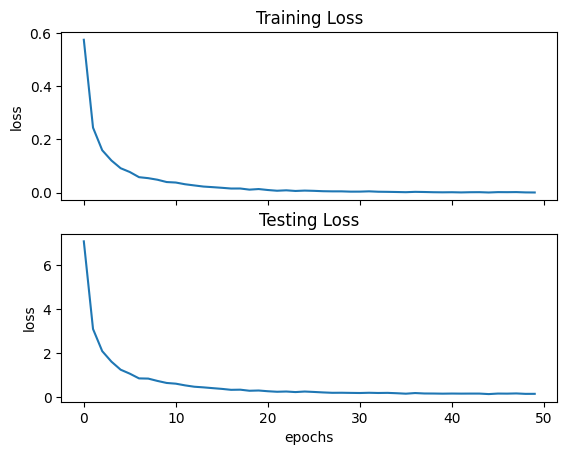

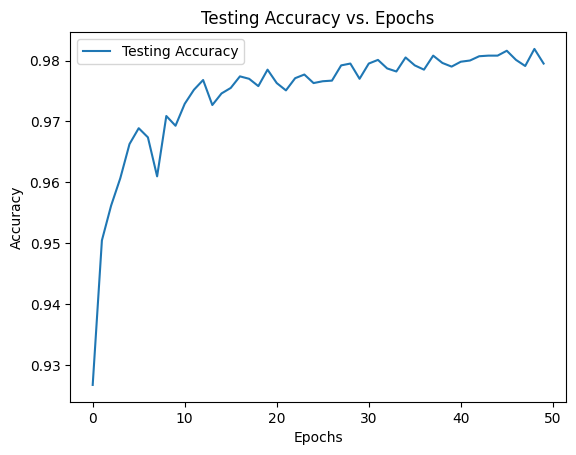

In [ ]:
import matplotlib.pyplot as plt

# Create three plots
fig, axs = plt.subplots(2)
axs[0].plot(train_loss_list)
axs[0].set_title('Training Loss')
axs[1].plot(test_loss_list)
axs[1].set_title('Testing Loss')

for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.figure()
plt.plot(test_accuracy_list,  label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy vs. Epochs")
plt.legend()



# Question 6: Concluding Remarks 
If you have been able to implement all the parts in Q.1.-Q.5., you can now feel proud of yourself for having learned the basics of a deep learning pipeline that powers all the modern AI applications. Of course, the exact implementation varies in the input and network design for more complex applications, but the pipeline remains the same. In fact, we went beyond the conventional deep learning, and implemented a spiking deep learning algorithm which is not a skill that many people possess. 

Now that you know the basic implementation, there are lots of directions which you can pursue if you are interested in this research area- how do the hyper-parameters such as the pseudo-gradient window affect the network training process? How much training data do you need to achieve good performance? How does the amount of training data vary with the complexity of the task? To what limits can you push the spike encoding, i.e. what is the minimum timesteps you need to achieve good performance? 

You do not need to answer these questions in this assignment but it is something to think about if you are interested. 

**As the concluding question of the course, can you describe what are the three key lessons you learned from the course and why is it important to learn them?**

## Answer 6

The course has been very informative and helped me grasp key concepts of brain inspired computing.

The key lessons learnt:

1. The memory representation in the Brain. The hopfield network study was very fascinating and it made me understand that the memories are stored in the stength of connections bteween the neurons.

2. How information is transfered. The course explained about synaptic plasticity , the information propogation as enocded spikes from the presynaptic to postsynaptic neuron. The chemistry involved was interesting and  the way we used this knowledge to build a computation replica which is biologically relevant


3. The key reason of taking this course was to learn about the brain and ways to build brain machine interfaces(BMI's) . BMI's have to process a lot of data in real time using less power. This course goes through a lot of low computational algorithms which provides great results which are in par with the complicated high computational algorithms.

Overall this has been an amazing course.